# CartPole solver using advantage actor-critic (A2C) with a single classical policy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

import eqmarl
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow.keras as keras
import tensorflow as tf

2024-02-01 13:18:04.723253: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
import numpy as np

state_bounds = tf.convert_to_tensor(np.array([2.4, 2.5, 0.21, 2.5], dtype='float32'))

def generate_model_actor_classical(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Lambda(lambda x: x/state_bounds)] # Normalizes input states.]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model


def generate_model_critic_classical(units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Lambda(lambda x: x/state_bounds)] # Normalizes input states.]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [5]:
n_actions = 2

In [6]:
# Classical policy.
model_actor = generate_model_actor_classical(
    n_actions=n_actions,
    units=[256],
    name=f"actor-classical"
    )
optimizer_actor = keras.optimizers.Adam(learning_rate=3e-4)

model_actor.build((None, 4))
model_actor.summary()

Model: "actor-classical"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 4)                 0         
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
 policy (Dense)              (None, 2)                 514       
                                                                 
Total params: 1,794
Trainable params: 1,794
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Classical critic.
model_critic = generate_model_critic_classical(
    units=[256],
    name=f"critic-classical"
    )
optimizer_critic = keras.optimizers.Adam(learning_rate=3e-4)

model_critic.build((None, 4))
model_critic.summary()

Model: "critic-classical"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 4)                 0         
                                                                 
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 256)               1280      
                                                                 
 v (Dense)                   (None, 1)                 257       
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Training

In [8]:
# rewards = [10, 20, 30]
# Qvals = np.zeros_like(rewards)
# Qval = 1
# for t in reversed(range(len(rewards))):
#     Qval = rewards[t] + gamma * Qval
#     print(f"{t=}, {rewards[t]=}, {Qval=}")
#     Qvals[t] = Qval
# print(Qvals)


# rewards_history = [1, 1, 1, 1]
# returns = []
# discounted_sum = 0
# for r in rewards_history[::-1]:
#     discounted_sum = r + gamma * discounted_sum
#     returns.insert(0, discounted_sum)
# returns

In [9]:
gamma = 0.99
alpha = 0.001
env = gym.make('CartPole-v1')

algo = eqmarl.algorithms.A2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    )

reward_history, metrics_history = algo.train(n_episodes=3000, max_steps_per_episode=500)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 2185:  73%|███████▎  | 2185/3000 [09:00<03:21,  4.04episode/s, episode_reward=397]

Terminating early at episode 2185


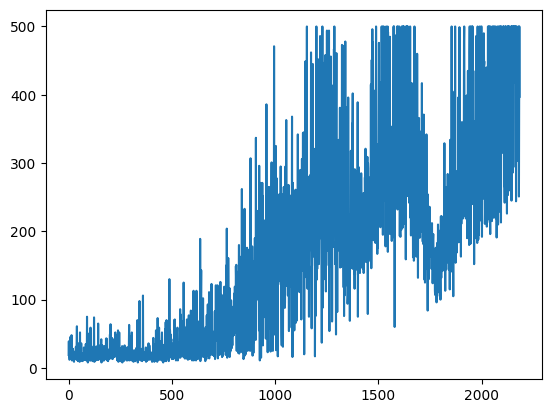

In [11]:
plt.plot(reward_history)